In [1]:
# =============================================
# 1. CONFIGURACIÓN INICIAL
# =============================================

import pandas as pd
import numpy as np
import sqlite3
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# Ruta al DW
db_path = "C:/Users/Nico/Desktop/DATA SCIENCE/PP- VOLUNTAREADO/chivas-ml/data/external/chivas_dw.sqlite"

# Conexión
conn = sqlite3.connect(db_path)

# Cargar la vista combinada
df = pd.read_sql_query("SELECT * FROM vw_entrenamiento_sugerencias_puras", conn)

# Cerrar conexión
conn.close()

print(f"Registros cargados: {len(df)}")
df.head()


Registros cargados: 4450


,id_jugador,Microciclo_Num,Fecha,Tipo_Microciclo,Fase,Tipo_Dia,Intensidad_plan,EsPartido,EsDescanso,prob_riesgo,...,Distancia_total,HMLD_m,HSR_abs_m,Acc_3,Dec_3,Sprints_cantidad,Sprints_vel_max_kmh,Player_Load,RPE,Rendimiento_Real
0,1,1,2025-05-21,Pretemporada,Evaluaciones/Introducción 1,ENTRENO,0.0,0,0,NaN,...,0,0,0,0,0,0,0.0,0,0,0.0
1,2,1,2025-05-21,Pretemporada,Evaluaciones/Introducción 1,ENTRENO,0.0,0,0,NaN,...,0,0,0,0,0,0,0.0,0,0,0.0
2,3,1,2025-05-21,Pretemporada,Evaluaciones/Introducción 1,ENTRENO,0.0,0,0,NaN,...,0,0,0,0,0,0,0.0,0,0,0.0
3,4,1,2025-05-21,Pretemporada,Evaluaciones/Introducción 1,ENTRENO,0.0,0,0,NaN,...,0,0,0,0,0,0,0.0,0,0,0.0
4,5,1,2025-05-21,Pretemporada,Evaluaciones/Introducción 1,ENTRENO,0.0,0,0,NaN,...,0,0,0,0,0,0,0.0,0,0,0.0


In [2]:
# =============================================
# 2. LIMPIEZA Y PREPROCESAMIENTO
# =============================================

# Eliminamos jugadores o fechas nulas
df = df.dropna(subset=["id_jugador", "Fecha"])

# Convertimos fecha a datetime
df["Fecha"] = pd.to_datetime(df["Fecha"])

# Reemplazamos nulos en Intensidad_plan con 0 (ya que los partidos quedan en NULL)
df["Intensidad_plan"] = df["Intensidad_plan"].fillna(0)

# Codificamos columnas categóricas
df["Tipo_Dia"] = df["Tipo_Dia"].astype(str)
df["Tipo_Microciclo"] = df["Tipo_Microciclo"].astype(str)
df["nivel_riesgo"] = df["nivel_riesgo"].astype(str)

# Eliminamos outliers extremos en cargas (opcional)
#for col in ["Distancia_total", "HMLD_m", "HSR_abs_m", "Sprints_cantidad"]:
#    df = df[df[col] < df[col].quantile(0.99)]


In [3]:
# =============================================
# 2.1 FILTRO DE JUGADORES Y MICRO-CICLOS
# =============================================

# Jugadores que deben excluirse
jugadores_excluir = [1, 2, 3, 12, 30]

# Filtrar jugadores no válidos
df = df[~df["id_jugador"].isin(jugadores_excluir)]

# Filtrar solo microciclos de competencia
df = df[df["Tipo_Microciclo"].str.lower().str.contains("competencia")]

print(f"✅ Registros después del filtrado: {len(df)}")
print(f"Jugadores únicos: {df['id_jugador'].nunique()}")
df[["id_jugador", "Tipo_Microciclo"]].drop_duplicates().head()


✅ Registros después del filtrado: 2541
Jugadores únicos: 26


,id_jugador,Tipo_Microciclo
1460,4,Competencia
1461,5,Competencia
1462,6,Competencia
1463,7,Competencia
1464,8,Competencia


In [4]:
# =============================================
# 🔹 Análisis inicial del dataset
# =============================================

import matplotlib.pyplot as plt
import seaborn as sns

# Verificar tipos de datos y valores nulos
df.info()
print("\nValores nulos por columna:\n", df.isna().sum())

# Descripción estadística básica
display(df.describe())


<class 'pandas.core.frame.DataFrame'>
Index: 2541 entries, 1460 to 4449
Data columns (total 34 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   id_jugador                2541 non-null   int64         
 1   Microciclo_Num            2541 non-null   int64         
 2   Fecha                     2541 non-null   datetime64[ns]
 3   Tipo_Microciclo           2541 non-null   object        
 4   Fase                      2541 non-null   object        
 5   Tipo_Dia                  2541 non-null   object        
 6   Intensidad_plan           2541 non-null   float64       
 7   EsPartido                 2541 non-null   int64         
 8   EsDescanso                2541 non-null   int64         
 9   prob_riesgo               2541 non-null   float64       
 10  prob_riesgo_suavizado_3d  2541 non-null   float64       
 11  prob_riesgo_suavizado_5d  2541 non-null   float64       
 12  nivel_riesgo          

,id_jugador,Microciclo_Num,Fecha,Intensidad_plan,EsPartido,EsDescanso,prob_riesgo,prob_riesgo_suavizado_3d,prob_riesgo_suavizado_5d,CE_7d,...,Distancia_total,HMLD_m,HSR_abs_m,Acc_3,Dec_3,Sprints_cantidad,Sprints_vel_max_kmh,Player_Load,RPE,Rendimiento_Real
count,2541.000000,2541.000000,2541,2541.000000,2541.000000,2541.000000,2541.000000,2541.000000,2541.000000,2541.000000,...,2541.000000,2541.000000,2541.000000,2541.000000,2541.000000,2541.000000,2541.000000,2541.000000,2541.000000,2541.000000
mean,17.198741,14.992523,2025-08-27 20:06:31.027154688,0.092090,0.099567,0.214876,0.376403,0.381622,0.386939,1794.678749,...,2988.633609,491.280598,119.036993,19.434868,21.283747,2.321921,13.994176,35.219205,2.677686,34.345539
min,4.000000,8.000000,2025-07-07 00:00:00,-3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,10.000000,11.000000,2025-08-01 00:00:00,-1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1071.700000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,18.000000,15.000000,2025-08-28 00:00:00,0.000000,0.000000,0.000000,0.010000,0.012500,0.230000,1717.800000,...,3007.000000,386.000000,35.000000,16.000000,17.000000,0.000000,20.100000,24.000000,3.000000,27.824933
75%,24.000000,19.000000,2025-09-24 00:00:00,1.000000,0.000000,0.000000,0.995000,0.990000,0.962500,2479.200000,...,4750.000000,807.000000,175.000000,33.000000,36.000000,3.000000,26.100000,68.000000,5.000000,60.170097
max,31.000000,22.000000,2025-10-19 00:00:00,3.000000,1.000000,1.000000,1.000000,1.000000,1.000000,5410.500000,...,13695.000000,2809.000000,1110.000000,94.000000,107.000000,27.000000,34.000000,186.000000,10.000000,123.333333
std,7.943418,4.357854,NaN,1.350481,0.299481,0.410817,0.474817,0.451835,0.426700,1044.965559,...,2834.998841,533.185380,176.474542,19.840828,22.017838,3.845780,12.829782,38.554384,2.774251,34.472262


C:\Users\Nico\AppData\Local\Temp\ipykernel_15548\3001743947.py:23: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
c:\Users\Nico\Desktop\DATA SCIENCE\PP- VOLUNTAREADO\chivas-ml\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


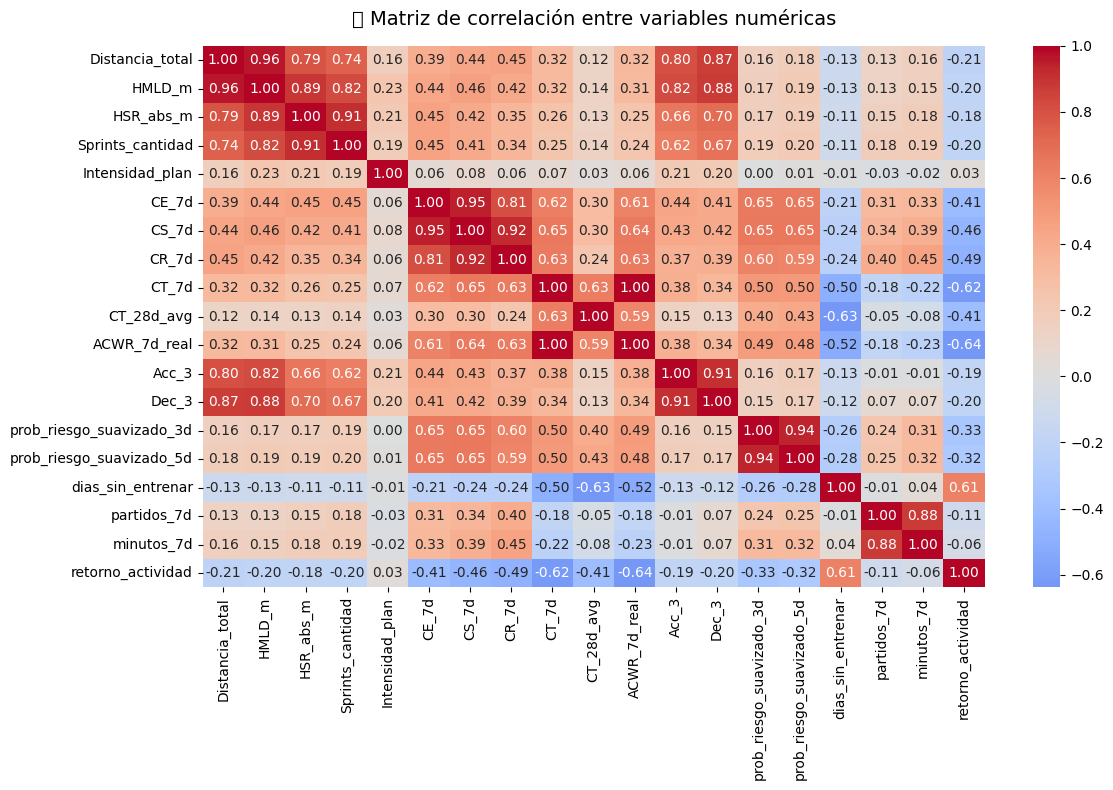

🔝 Top 15 correlaciones positivas:


,Variable_1,Variable_2,Correlacion
117,CT_7d,ACWR_7d_real,0.995129
0,Distancia_total,HMLD_m,0.955834
80,CE_7d,CS_7d,0.945788
156,prob_riesgo_suavizado_3d,prob_riesgo_suavizado_5d,0.942370
93,CS_7d,CR_7d,0.917535
35,HSR_abs_m,Sprints_cantidad,0.911278
143,Acc_3,Dec_3,0.905506
18,HMLD_m,HSR_abs_m,0.888711
28,HMLD_m,Dec_3,0.875974
168,partidos_7d,minutos_7d,0.875348



🔻 Top 15 correlaciones negativas:


,Variable_1,Variable_2,Correlacion
142,ACWR_7d_real,retorno_actividad,-0.638266
131,CT_28d_avg,dias_sin_entrenar,-0.632633
125,CT_7d,retorno_actividad,-0.615441
139,ACWR_7d_real,dias_sin_entrenar,-0.523767
122,CT_7d,dias_sin_entrenar,-0.501103
115,CR_7d,retorno_actividad,-0.490780
104,CS_7d,retorno_actividad,-0.461279
92,CE_7d,retorno_actividad,-0.414753
134,CT_28d_avg,retorno_actividad,-0.408369
160,prob_riesgo_suavizado_3d,retorno_actividad,-0.325033


In [7]:
# =============================================
# 2.2 ANÁLISIS DE CORRELACIÓN ENTRE VARIABLES
# =============================================

import matplotlib.pyplot as plt
import seaborn as sns

# Seleccionamos solo las variables numéricas relevantes
corr_cols = [
    "Distancia_total", "HMLD_m", "HSR_abs_m", "Sprints_cantidad",
    "Intensidad_plan", "CE_7d", "CS_7d", "CR_7d", "CT_7d", "CT_28d_avg",
    "ACWR_7d_real", "Acc_3", "Dec_3", "prob_riesgo_suavizado_3d", "prob_riesgo_suavizado_5d",
    "dias_sin_entrenar", "partidos_7d", "minutos_7d", "retorno_actividad"
]

# Creamos la matriz de correlación
corr_matrix = df[corr_cols].corr(method="pearson")

# Heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", center=0)
plt.title("🔍 Matriz de correlación entre variables numéricas", fontsize=14, pad=15)
plt.tight_layout()
plt.show()

# ========================
# PARES CON MAYOR CORRELACIÓN
# ========================

# Aplanamos la matriz y filtramos duplicados
corr_pairs = (
    corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
    .stack()
    .reset_index()
)
corr_pairs.columns = ["Variable_1", "Variable_2", "Correlacion"]

# Top correlaciones positivas
top_pos = corr_pairs.sort_values("Correlacion", ascending=False).head(15)

# Top correlaciones negativas
top_neg = corr_pairs.sort_values("Correlacion", ascending=True).head(15)

print("🔝 Top 15 correlaciones positivas:")
display(top_pos)

print("\n🔻 Top 15 correlaciones negativas:")
display(top_neg)



🔹 Correlaciones más altas con Distancia_total:


HMLD_m              0.955834
Dec_3               0.867345
Acc_3               0.802540
HSR_abs_m           0.792423
Sprints_cantidad    0.741300
CR_7d               0.448601
CS_7d               0.436850
CE_7d               0.393694
ACWR_7d_real        0.322772
CT_7d               0.321543
Name: Distancia_total, dtype: float64

C:\Users\Nico\AppData\Local\Temp\ipykernel_15548\2296130260.py:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
C:\Users\Nico\AppData\Local\Temp\ipykernel_15548\2296130260.py:35: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
c:\Users\Nico\Desktop\DATA SCIENCE\PP- VOLUNTAREADO\chivas-ml\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


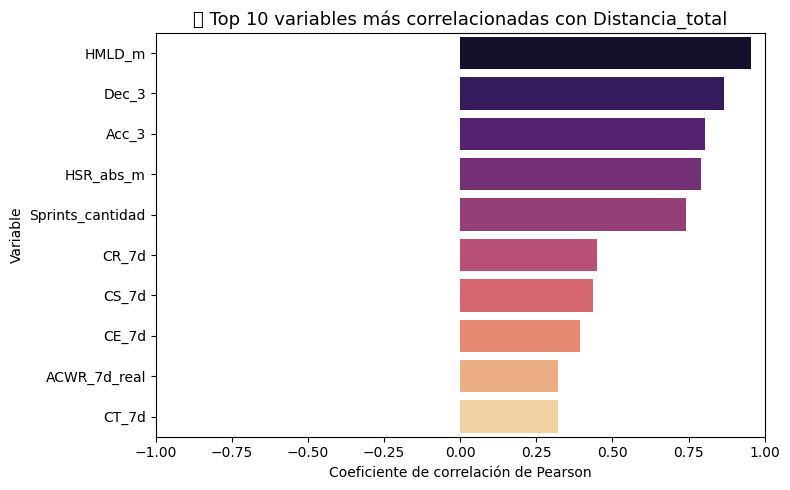


🔹 Correlaciones más altas con HMLD_m:


Distancia_total     0.955834
HSR_abs_m           0.888711
Dec_3               0.875974
Acc_3               0.821996
Sprints_cantidad    0.821301
CS_7d               0.463506
CE_7d               0.435562
CR_7d               0.418911
CT_7d               0.316595
ACWR_7d_real        0.313999
Name: HMLD_m, dtype: float64

C:\Users\Nico\AppData\Local\Temp\ipykernel_15548\2296130260.py:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
C:\Users\Nico\AppData\Local\Temp\ipykernel_15548\2296130260.py:35: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
c:\Users\Nico\Desktop\DATA SCIENCE\PP- VOLUNTAREADO\chivas-ml\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


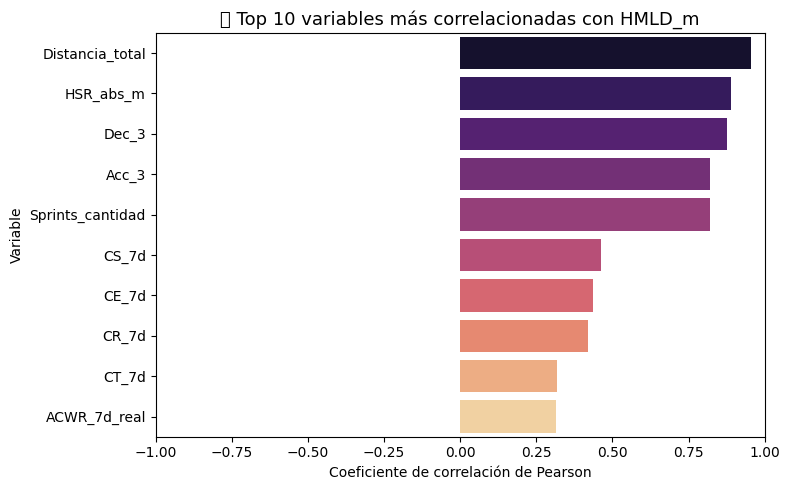


🔹 Correlaciones más altas con HSR_abs_m:


Sprints_cantidad    0.911278
HMLD_m              0.888711
Distancia_total     0.792423
Dec_3               0.698420
Acc_3               0.659601
CE_7d               0.452723
CS_7d               0.422740
CR_7d               0.347916
CT_7d               0.257796
ACWR_7d_real        0.252643
Name: HSR_abs_m, dtype: float64

C:\Users\Nico\AppData\Local\Temp\ipykernel_15548\2296130260.py:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
C:\Users\Nico\AppData\Local\Temp\ipykernel_15548\2296130260.py:35: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
c:\Users\Nico\Desktop\DATA SCIENCE\PP- VOLUNTAREADO\chivas-ml\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


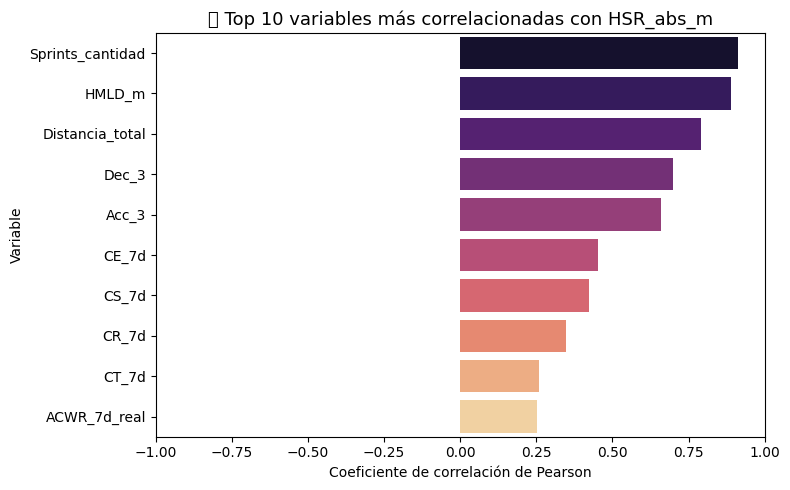


🔹 Correlaciones más altas con Sprints_cantidad:


HSR_abs_m          0.911278
HMLD_m             0.821301
Distancia_total    0.741300
Dec_3              0.669878
Acc_3              0.620436
CE_7d              0.451384
CS_7d              0.413148
CR_7d              0.342873
CT_7d              0.248835
ACWR_7d_real       0.242355
Name: Sprints_cantidad, dtype: float64

C:\Users\Nico\AppData\Local\Temp\ipykernel_15548\2296130260.py:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
C:\Users\Nico\AppData\Local\Temp\ipykernel_15548\2296130260.py:35: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
c:\Users\Nico\Desktop\DATA SCIENCE\PP- VOLUNTAREADO\chivas-ml\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


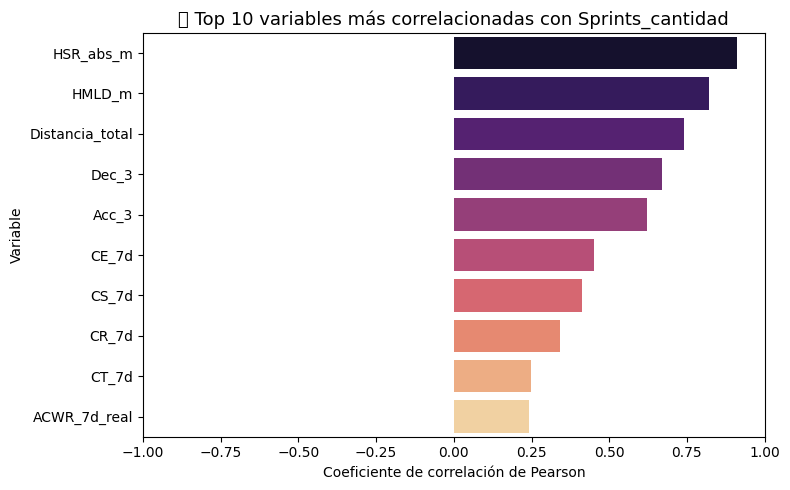


🔹 Correlaciones más altas con Acc_3:


Dec_3               0.905506
HMLD_m              0.821996
Distancia_total     0.802540
HSR_abs_m           0.659601
Sprints_cantidad    0.620436
CE_7d               0.438583
CS_7d               0.429096
CT_7d               0.379876
ACWR_7d_real        0.377700
CR_7d               0.374898
Name: Acc_3, dtype: float64

C:\Users\Nico\AppData\Local\Temp\ipykernel_15548\2296130260.py:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
C:\Users\Nico\AppData\Local\Temp\ipykernel_15548\2296130260.py:35: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
c:\Users\Nico\Desktop\DATA SCIENCE\PP- VOLUNTAREADO\chivas-ml\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


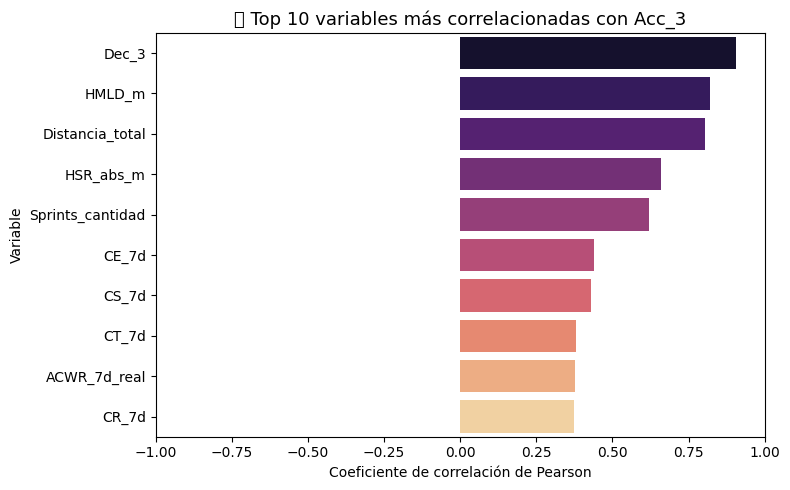


🔹 Correlaciones más altas con Dec_3:


Acc_3               0.905506
HMLD_m              0.875974
Distancia_total     0.867345
HSR_abs_m           0.698420
Sprints_cantidad    0.669878
CS_7d               0.423890
CE_7d               0.412607
CR_7d               0.386709
CT_7d               0.338349
ACWR_7d_real        0.338194
Name: Dec_3, dtype: float64

C:\Users\Nico\AppData\Local\Temp\ipykernel_15548\2296130260.py:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
C:\Users\Nico\AppData\Local\Temp\ipykernel_15548\2296130260.py:35: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
c:\Users\Nico\Desktop\DATA SCIENCE\PP- VOLUNTAREADO\chivas-ml\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


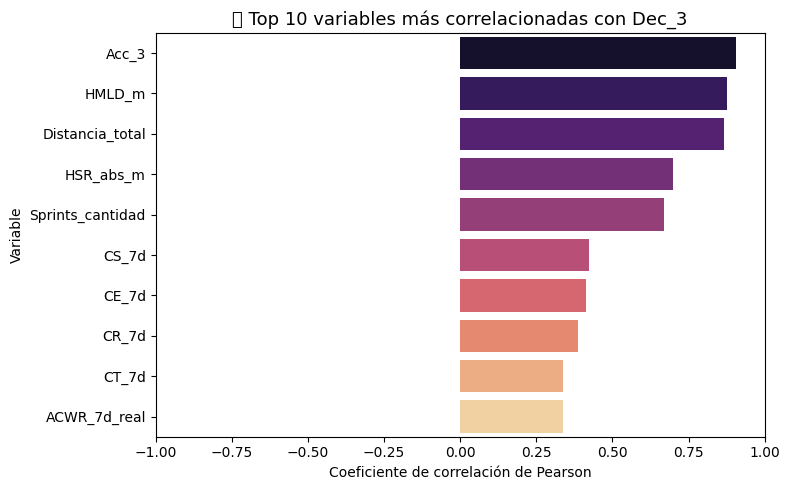

In [8]:
# =============================================
# 2.3 CORRELACIÓN POR TARGET (CARGAS PURAS + NEUROMUSCULARES)
# =============================================

# Nuevos targets: cargas físicas + aceleraciones y desaceleraciones
targets = [
    "Distancia_total", "HMLD_m", "HSR_abs_m", "Sprints_cantidad",
    "Acc_3", "Dec_3"
]

for target in targets:
    if target not in corr_matrix.columns:
        print(f"⚠️ {target} no está en la matriz de correlación, se omite.")
        continue

    # Calculamos la correlación de todas las variables numéricas con el target
    corr_target = corr_matrix[target].sort_values(ascending=False)
    corr_target = corr_target.drop(target, errors="ignore")

    # Mostramos el top 10 en tabla
    print(f"\n🔹 Correlaciones más altas con {target}:")
    display(corr_target.head(10))

    # Mostramos el top 10 en gráfico
    plt.figure(figsize=(8, 5))
    sns.barplot(
        x=corr_target.head(10).values,
        y=corr_target.head(10).index,
        palette="magma"
    )
    plt.title(f"🔍 Top 10 variables más correlacionadas con {target}", fontsize=13)
    plt.xlabel("Coeficiente de correlación de Pearson")
    plt.ylabel("Variable")
    plt.xlim(-1, 1)
    plt.tight_layout()
    plt.show()


## 📊 Análisis de correlaciones entre métricas físicas

El objetivo de este análisis fue identificar las relaciones lineales más fuertes entre las variables de rendimiento físico diario y las métricas de carga acumulada.  
Se incluyeron tanto **métricas de carga externa directa** (Distancia_total, HMLD_m, HSR_abs_m, Sprints_cantidad) como **indicadores neuromusculares** (Acc_3, Dec_3), además de variables de carga compuesta semanal (CE_7d, CS_7d, CR_7d, CT_7d, ACWR_7d_real).

---

### 🔹 1. Correlaciones principales

#### 🏃‍♂️ Distancia_total
- Altamente correlacionada con **HMLD_m (0.96)**, **Dec_3 (0.87)** y **Acc_3 (0.80)**.  
- Muestra una relación fuerte con **HSR_abs_m (0.79)** y **Sprints_cantidad (0.74)**.  
- Las correlaciones con las cargas semanales (CE_7d, CS_7d, CR_7d) son moderadas (≈ 0.4–0.45).  

💬 *Interpretación:* representa el volumen general de trabajo, estrechamente vinculado al esfuerzo total y las demandas neuromusculares del jugador.

---

#### ⚡ HMLD_m (High Metabolic Load Distance)
- Fuerte relación con **Distancia_total (0.96)**, **HSR_abs_m (0.89)** y **Dec_3 (0.88)**.  
- Buena correlación con **Acc_3 (0.82)** y **Sprints_cantidad (0.82)**.  
- Con las cargas ponderadas semanales la relación es moderada (≈ 0.43–0.46).  

💬 *Interpretación:* integra tanto volumen como intensidad; es uno de los mejores indicadores del esfuerzo real y responde de forma sensible a las variaciones de carga explosiva.

---

#### 🏎️ HSR_abs_m (High Speed Running)
- Máxima relación con **Sprints_cantidad (0.91)** y **HMLD_m (0.89)**.  
- Moderada correlación con **Acc_3 (0.66)** y **Dec_3 (0.70)**.  
- Asociaciones consistentes con cargas semanales (CE_7d ≈ 0.45).  

💬 *Interpretación:* refleja intensidad de desplazamientos; es un componente clave del estrés físico acumulado y un predictor de sobrecarga aguda.

---

#### 🧨 Sprints_cantidad
- Altamente correlacionada con **HSR_abs_m (0.91)**, **HMLD_m (0.82)** y **Distancia_total (0.74)**.  
- Fuerte relación con **Dec_3 (0.67)** y **Acc_3 (0.62)**.  
- Correlaciones moderadas con cargas semanales (CE_7d, CS_7d ≈ 0.4–0.45).  

💬 *Interpretación:* cuantifica esfuerzos explosivos, asociada tanto a intensidad como a potencia muscular.

---

#### ⚙️ Acc_3 (Aceleraciones)
- Correlación máxima con **Dec_3 (0.91)**, seguida de **HMLD_m (0.82)** y **Distancia_total (0.80)**.  
- Moderadas con **HSR_abs_m (0.66)** y **Sprints_cantidad (0.62)**.  
- Relación coherente con **CE_7d y CS_7d (≈ 0.43–0.44)**.  

💬 *Interpretación:* es un excelente indicador de *demanda neuromuscular* y del estrés asociado a cambios bruscos de ritmo.

---

#### 🛑 Dec_3 (Desaceleraciones)
- Muy fuerte correlación con **Acc_3 (0.91)**, **HMLD_m (0.88)** y **Distancia_total (0.87)**.  
- Buena asociación con **HSR_abs_m (0.70)** y **Sprints_cantidad (0.67)**.  
- Correlación moderada con métricas semanales (~0.4).  

💬 *Interpretación:* refleja acciones excéntricas y control muscular; es un marcador sensible de carga excéntrica acumulada y riesgo de fatiga.

---

### 🧩 2. Conclusiones generales

1. **Alta multicolinealidad interna:**  
   Las métricas físicas puras (`Distancia_total`, `HMLD_m`, `HSR_abs_m`, `Sprints_cantidad`, `Acc_3`, `Dec_3`) presentan correlaciones muy altas entre sí (r > 0.7), indicando que describen un mismo eje fisiológico de *intensidad y volumen*.  
   👉 Será necesario reducir dimensiones o seleccionar una variable representativa por grupo para evitar redundancia.

2. **Coherencia fisiológica:**  
   Las cargas semanales (`CE_7d`, `CS_7d`, `CR_7d`, `CT_7d`) muestran relaciones consistentes con las métricas físicas, confirmando la validez del modelo de acumulación y monitoreo de carga.

3. **Componente neuromuscular destacado:**  
   `Acc_3` y `Dec_3` presentan correlaciones robustas con todas las métricas de desplazamiento, consolidándose como indicadores clave de *estrés mecánico y potencia*.

4. **Correlaciones moderadas con el ACWR:**  
   La relación entre las métricas diarias y el `ACWR_7d_real` (≈ 0.3–0.4) indica que el índice de carga aguda-crónica no depende exclusivamente del volumen, sino también de la consistencia en la distribución de cargas.

---

### ✅ **Implicaciones para el modelo de IA**

- El modelo de **sugerencias de carga** deberá priorizar variables representativas de cada componente:
  - **Volumen:** `Distancia_total` o `CT_7d`
  - **Intensidad:** `HSR_abs_m` o `HMLD_m`
  - **Explosividad / Potencia:** `Acc_3` y `Dec_3`
  - **Equilibrio agudo-crónico:** `ACWR_7d_real`
- Se recomienda aplicar una **reducción de dimensionalidad (PCA)** o selección de features basada en importancia (Random Forest o mutual info) antes del entrenamiento del modelo predictivo.

---

🧠 *Conclusión final:*  
El conjunto de variables muestra una coherencia biomecánica sólida. Las métricas puras y neuromusculares son fuertemente interdependientes y reflejan una misma estructura de carga física.  
Esto confirma que el dataset está correctamente construido y listo para avanzar hacia la etapa de **modelado supervisado de sugerencias de entrenamiento**.


### **PASOS A SEGUIR**
 Tenemos dos caminos a elegir ya que hay demasiadas variables correlacionedas y debemos quitar ruido antes de comenzar a entrenar el modelo de ML. 
 Podemos seleccionar las features más relevante o utilizar PCA para combinar las variables principales.
 La primera se puede presentar de forma más clara al PF, la segunda sirve para el backend.
 Vamos a realizar las dos y ver que resultados arroja